In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from matplotlib.colors import ListedColormap
import seaborn as sns

1. Generación de datos simulados

In [54]:
np.random.seed(42)
n = 950  #Aumentamos el numero de muestras

fiebre = np.random.rand(n)
tos = np.random.rand(n)
dolor_muscular = np.random.rand(n)
perdida_olfato = np.random.rand(n)
fatiga = np.random.rand(n)

labels = []
for i in range(n):
    if perdida_olfato[i] > 0.6 and fiebre[i] > 0.5:
        labels.append("COVID-19")
    elif fiebre[i] > 0.5 and dolor_muscular[i] > 0.4:
        labels.append("Gripe")
    else:
        labels.append("Resfriado")

df = pd.DataFrame({
    'fiebre': fiebre,
    'tos': tos,
    'dolor_muscular': dolor_muscular,
    'perdida_olfato': perdida_olfato,
    'fatiga': fatiga,
    'enfermedad': labels
})

df.head()

,fiebre,tos,dolor_muscular,perdida_olfato,fatiga,enfermedad
0,0.374540,0.600517,0.554227,0.656631,0.296358,Resfriado
1,0.950714,0.665037,0.005230,0.240399,0.938316,Resfriado
2,0.731994,0.175371,0.760991,0.191593,0.818740,Gripe
3,0.598658,0.914412,0.035311,0.918239,0.983567,COVID-19
4,0.156019,0.418771,0.745734,0.101804,0.259671,Resfriado


2. División en entrenamiento y prueba

In [55]:
X = df.drop('enfermedad', axis=1)
y = df['enfermedad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

3. Modelo K-Nearest Neighbors (KNN)

In [70]:
knn = KNeighborsClassifier(n_neighbors=8, weights='distance') # Aumentamos n_neighbors a 8


knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

print("Métricas KNN:")
print(classification_report(y_test, y_pred_knn))




Métricas KNN:
              precision    recall  f1-score   support

    COVID-19       0.86      0.87      0.87        63
       Gripe       0.87      0.83      0.85        48
   Resfriado       0.93      0.94      0.93       174

    accuracy                           0.91       285
   macro avg       0.89      0.88      0.88       285
weighted avg       0.91      0.91      0.91       285



Miramos clase por clase hay cambios:

COVID-19:

n=5:precision 0.90, recall 0.86

n=8:precision 0.86, recall 0.87

-Con n=8 la precisión bajó un poco pero el recall subió ligeramente.

Esto indica que al aumentar vecinos, el modelo se vuelve un poco más conservador en predecir COVID-19 pero detecta más casos reales.

Gripe:

n=5: precision 0.82, recall 0.88

n=8: precision 0.87, recall 0.83

- Aquí pasa lo contrario: la precisión mejora (menos falsos positivos) pero el recall baja (menos casos reales detectados).

Resfriado:

Cambios mínimos: precision y recall siguen muy altas (0.93–0.94).

Conclusión sobre cambiar n_neighbors

Efecto general:

Cambiar de 5 a 8 vecinos suaviza las fronteras de decisión de KNN.

Esto hace que el modelo sea menos sensible a casos individuales o ruido.

Precisión vs Recall:

Algunas clases (COVID-19) pierden un poco de precisión pero ganan recall.

Otras (Gripe) ganan precisión pero pierden recall.

Esto es típico: aumentar n_neighbors genera un compromiso entre precisión y recall dependiendo de la clase.

Accuracy global:

No cambia (0.91), porque las mejoras y pérdidas en diferentes clases se compensan.

Interpretación práctica:

Con n_neighbors=5, el modelo es más “agresivo” y se ajusta más a los casos raros, pero puede cometer más errores puntuales.

Con n_neighbors=8, el modelo es más estable y generalizable, ideal si quieres evitar decisiones muy extremas basadas en pocos vecinos.


4. Árbol de Decisión

In [57]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=4, #el árbol no podrá tener más de 4 niveles.
                                                min_samples_split=5, #un nodo se dividirá solo si tiene al menos 5 muestras.
                                                min_samples_leaf=2, #asegura que cada hoja del árbol tenga al menos 2 muestras.
                                                random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

print("Métricas Árbol de Decisión:")
print(classification_report(y_test, y_pred_tree))

Métricas Árbol de Decisión:
              precision    recall  f1-score   support

    COVID-19       1.00      1.00      1.00        63
       Gripe       1.00      1.00      1.00        48
   Resfriado       1.00      1.00      1.00       174

    accuracy                           1.00       285
   macro avg       1.00      1.00      1.00       285
weighted avg       1.00      1.00      1.00       285



5. Evaluación de métricas

Accuracy KNN: 0.9052631578947369
Accuracy Árbol: 1.0


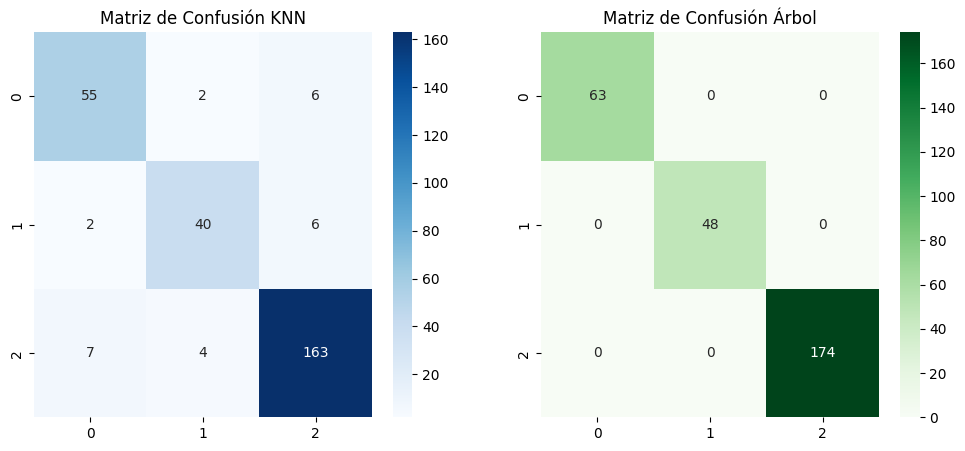

In [58]:
print("Accuracy KNN:", accuracy_score(y_test, y_pred_knn))
print("Accuracy Árbol:", accuracy_score(y_test, y_pred_tree))

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt="d", ax=ax[0], cmap="Blues")
ax[0].set_title("Matriz de Confusión KNN")

sns.heatmap(confusion_matrix(y_test, y_pred_tree), annot=True, fmt="d", ax=ax[1], cmap="Greens")
ax[1].set_title("Matriz de Confusión Árbol")
plt.show()

COVID-19:
Correctamente detectados: 55
Erróneamente clasificados como Gripe o Resfriado: 2 + 6 = 8

El modelo acierta la mayoría, pero a veces confunde COVID con resfriado (6 casos).

Gripe:
Correctos: 40
Erróneos: 2 (COVID) + 6 (Resfriado) = 8

También se confunde algunas veces con Resfriado.

Resfriado:
Correctos: 163
Erróneos: 7 (COVID) + 4 (Gripe) = 11

Es la clase más fácil de predecir (muchas más muestras y menos confusión).

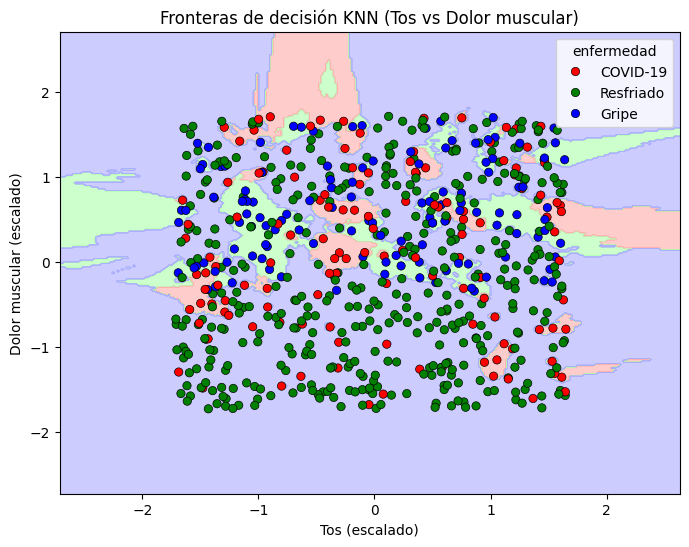

In [59]:
# Visualización Fronteras KNN 2D (Tos vs Dolor Muscular)

X_simple2 = df[["tos", "dolor_muscular"]]
y_simple2 = df["enfermedad"]
X_train_s2, X_test_s2, y_train_s2, y_test_s2 = train_test_split(X_simple2, y_simple2, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_s2_scaled = scaler.fit_transform(X_train_s2)
X_test_s2_scaled = scaler.transform(X_test_s2)


knn_simple2 = KNeighborsClassifier(n_neighbors=8, weights='distance')
knn_simple2.fit(X_train_s2_scaled, y_train_s2)


h = .02
x_min, x_max = X_train_s2_scaled[:, 0].min() - 1, X_train_s2_scaled[:, 0].max() + 1
y_min, y_max = X_train_s2_scaled[:, 1].min() - 1, X_train_s2_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = knn_simple2.predict(np.c_[xx.ravel(), yy.ravel()])
label_map = {"COVID-19": 0, "Gripe": 1, "Resfriado": 2}
Z = np.array([label_map[label] for label in Z])
Z = Z.reshape(xx.shape)
cmap_light = ListedColormap(["#FFAAAA", "#AAFFAA", "#AAAAFF"])
cmap_bold = ["red", "green", "blue"]
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.6)
sns.scatterplot(x=X_train_s2_scaled[:, 0], y=X_train_s2_scaled[:, 1], hue=y_train_s2, palette=cmap_bold, edgecolor="k")
plt.title("Fronteras de decisión KNN (Tos vs Dolor muscular)")
plt.xlabel("Tos (escalado)")
plt.ylabel("Dolor muscular (escalado)")
plt.show()

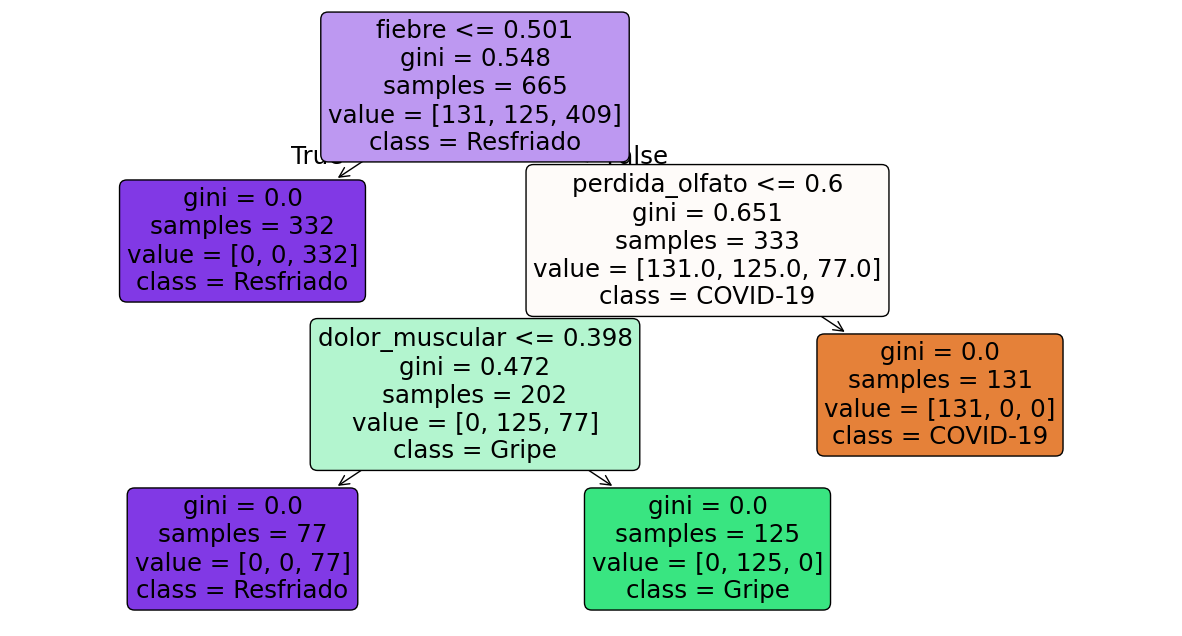

In [60]:
# Árbol de Decisión - Visualización

plt.figure(figsize=(15,8))
plot_tree(tree, feature_names=X.columns, class_names=tree.classes_, filled=True, rounded=True)
plt.show()